# UNet Review
- UNet Pytorch
- UNet: Convolutional Networks for Biomedical Image Segmentation
- https://youtube.com/watch?v=sSxdQq9CCx0&si=EnSIkaIECMiOmarE

In [1]:
import os
import numpy as np

import torch
import torch.nn as nn

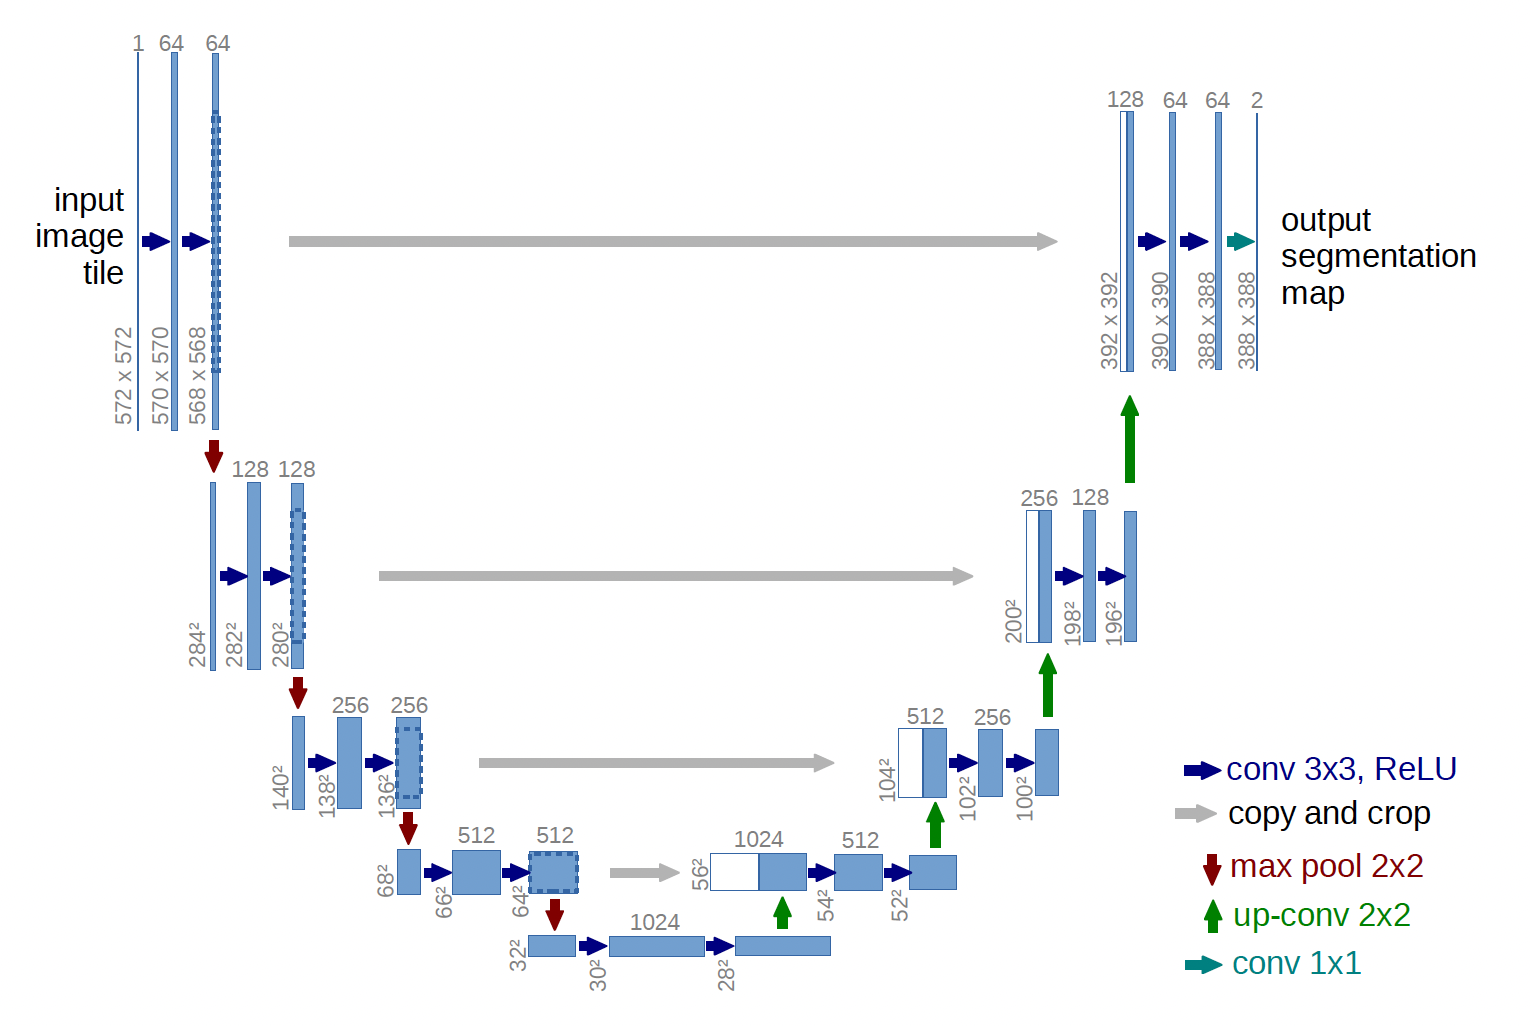

## UNet 구축

In [2]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        
        # conv 3x3, batch normalization, relu
        def CB(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True):
            layers = []
            layers += [nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                                 kernel_size=kernel_size, stride=stride, padding=padding, bias=bias)]
            layers += [nn.BatchNorm2d(num_features=out_channels)]
            layers += [nn.ReLU()]
            
            conv_block = nn.Sequential(*layers)
            return conv_block
        
        # UNet Encoder
        self.enc1_1 = CB(in_channels=1, out_channels=64)
        self.enc1_2 = CB(in_channels=64, out_channels=64)
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        
        self.enc2_1 = CB(in_channels=64, out_channels=128)
        self.enc2_2 = CB(in_channels=128, out_channels=128)
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        
        self.enc3_1 = CB(in_channels=128, out_channels=256)
        self.enc3_2 = CB(in_channels=256, out_channels=256)
        self.pool3 = nn.MaxPool2d(kernel_size=2)
        
        self.enc4_1 = CB(in_channels=256, out_channels=512)
        self.enc4_2 = CB(in_channels=512, out_channels=512)
        self.pool4 = nn.MaxPool2d(kernel_size=2)
        
        self.enc5_1 = CB(in_channels=512, out_channels=1024)
        
        # UNet Decoder
        self.dec5_1 = CB(in_channels=1024, out_channels=512)
        
        self.unpool4 = nn.ConvTranspose2d(in_channels=512, out_channels=512, kernel_size=2, stride=2, padding=0, bias=True)
        
        # in_channels = 512*2인 이유는 encoder에서 사용했던 피쳐맵을 decoder에서도 사용할 수 있도록
        # forward에서 dec와 enc을 concat해주기 때문 
        self.dec4_2 = CB(in_channels=512*2, out_channels=512)  
        self.dec4_1 = CB(in_channels=512, out_channels=256)
        
        self.unpool3 = nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size=2, stride=2, padding=0, bias=True)
        self.dec3_2 = CB(in_channels=256*2, out_channels=256)
        self.dec3_1 = CB(in_channels=256, out_channels=128)
        
        self.unpool2 = nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=2, stride=2, padding=0, bias=True)
        self.dec2_2 = CB(in_channels=128*2, out_channels=128)
        self.dec2_1 = CB(in_channels=128, out_channels=64)
        
        self.unpool1 = nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=2, stride=2, padding=0, bias=True)
        self.dec1_2 = CB(in_channels=64*2, out_channels=64)
        self.dec1_1 = CB(in_channels=64, out_channels=64)
        
        self.fc = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1, stride=1, padding=0, bias=True)
        
    def forward(self, x):
        # Encoder
        enc1_1 = self.enc1_1(x)
        enc1_2 = self.enc1_2(enc1_1)
        pool1 = self.pool1(enc1_2)

        enc2_1 = self.enc2_1(pool1)
        enc2_2 = self.enc2_2(enc2_1)
        pool2 = self.pool2(enc2_2)

        enc3_1 = self.enc3_1(pool2)
        enc3_2 = self.enc3_2(enc3_1)
        pool3 = self.pool3(enc3_2)

        enc4_1 = self.enc4_1(pool3)
        enc4_2 = self.enc4_2(enc4_1)
        pool4 = self.pool4(enc4_2)

        enc5_1 = self.enc5_1(pool4)

        # Decoder
        dec5_1 = self.dec5_1(enc5_1)

        unpool4 = self.unpool4(dec5_1)

        # UNet 구조 중 encoder에서 사용했던 피쳐맵을 decoder에서 동일하게 사용하도록 구축
        # dim=[0:batch, 1:channel, 2:height, 3:width]
        cat4 = torch.cat((unpool4, enc4_2), dim=1)
        dec4_2 = self.dec4_2(cat4)
        dec4_1 = self.dec4_1(dec4_2)

        unpool3 = self.unpool3(dec4_1)
        cat3 = torch.cat((unpool3, enc3_2), dim=1)
        dec3_2 = self.dec3_2(cat3)
        dec3_1 = self.dec3_1(dec3_2)

        unpool2 = self.unpool2(dec3_1)
        cat2 = torch.cat((unpool2, enc2_2), dim=1)
        dec2_2 = self.dec2_2(cat2)
        dec2_1 = self.dec2_1(dec2_2)

        unpool1 = self.unpool1(dec2_1)
        cat1 = torch.cat((unpool1, enc1_2), dim=1)
        dec1_2 = self.dec1_2(cat1)
        dec1_1 = self.dec1_1(dec1_2)

        x = self.fc(dec1_1)

        return x

In [3]:
model = UNet()
model

UNet(
  (enc1_1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (enc1_2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc2_1): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (enc2_2): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, cei

## UNet 실습 - Bio

In [4]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

from tqdm import tqdm
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

### 데이터
- ISBI Challenge 2012, segmentation of neuronal structures in EM stacks
- 해당 사이트 없어져서 아래 github에서 받아옴
- https://github.com/hanyoseob/youtube-cnn-002-pytorch-unet
- https://www.youtube.com/watch?v=rBb597ct_FQ&list=PLqtXapA2WDqbE6ghoiEJIrmEnndQ7ouys&index=6

In [5]:
# 데이터 저장경로
data_dir = './datasets'

name_label = 'train-labels.tif'
name_input = 'train-volume.tif'

img_label = Image.open(os.path.join(data_dir, name_label))
img_input = Image.open(os.path.join(data_dir, name_input))

ny, nx = img_label.size
nframe = img_label.n_frames

print('nx', nx)
print('ny', ny)
print('frame', nframe)

nx 512
ny 512
frame 30


In [6]:
# 데이터는 총 30프레임으로 구성되어 train:val:test=24:3:3
nframe_train = 24
nframe_val = 3
nframe_test = 3

# 데이터 나눠서 저장할 경로 설정
train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'val')
test_dir = os.path.join(data_dir, 'test')

# 경로 폴더 만들기
if not os.path.exists(train_dir):
    os.makedirs(train_dir)
if not os.path.exists(val_dir):
    os.makedirs(val_dir)
if not os.path.exists(test_dir):
    os.makedirs(test_dir)

In [7]:
# 데이터 랜덤 설정
id_frame = np.arange(nframe)
np.random.shuffle(id_frame)
print(id_frame)

[15 22 10  1 28  7  6  8 19 16  2 21 11 25 23 13  9 20 17 27  4  3 12 18
 26 14 24 29  5  0]


In [8]:
# 데이터 섞어서 train 저장
offset_nframe = 0
for i in range(nframe_train):
    img_label.seek(id_frame[i + offset_nframe])
    img_input.seek(id_frame[i + offset_nframe])
    
    label_ = np.asarray(img_label)
    input_ = np.asarray(img_input)
    
    np.save(os.path.join(train_dir, f'label_{i:03d}.npy'), label_)
    np.save(os.path.join(train_dir, f'input_{i:03d}.npy'), input_)

In [9]:
# 데이터 섞어서 val 저장
offset_nframe += nframe_train
for i in range(nframe_val):
    img_label.seek(id_frame[i + offset_nframe])
    img_input.seek(id_frame[i + offset_nframe])
    
    label_ = np.asarray(img_label)
    input_ = np.asarray(img_input)
    
    np.save(os.path.join(val_dir, f'label_{i:03d}.npy'), label_)
    np.save(os.path.join(val_dir, f'input_{i:03d}.npy'), input_)

In [10]:
# 데이터 섞어서 test 저장
offset_nframe += nframe_val
for i in range(nframe_test):
    img_label.seek(id_frame[i + offset_nframe])
    img_input.seek(id_frame[i + offset_nframe])
    
    label_ = np.asarray(img_label)
    input_ = np.asarray(img_input)
    
    np.save(os.path.join(test_dir, f'label_{i:03d}.npy'), label_)
    np.save(os.path.join(test_dir, f'input_{i:03d}.npy'), input_)

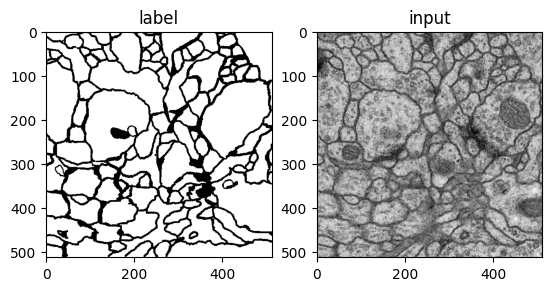

In [11]:
# 데이터 확인
plt.subplot(121)
plt.imshow(input_, cmap='gray')
plt.title('input')

plt.subplot(122)
plt.imshow(label_, cmap='gray')
plt.title('label')

plt.show()

In [12]:
# dataset
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        
        # 데이터 파일 리스트 받기
        lst_data = os.listdir(self.data_dir)
        
        lst_label = [f for f in lst_data if f.startswith('label')]
        lst_input = [f for f in lst_data if f.startswith('input')]
        
        lst_label.sort()
        lst_input.sort()
        
        self.lst_label = lst_label
        self.lst_input = lst_input
        
    def __len__(self):
        return len(self.lst_label)
    
    def __getitem__(self, index):
        labels = np.load(os.path.join(self.data_dir, self.lst_label[index]))
        inputs = np.load(os.path.join(self.data_dir, self.lst_input[index]))
        
        # normalization
        labels = labels/255.0
        inputs = inputs/255.0
        
        # torch는 반드시 3차원이여야하기 때문에 채널이 없는 경우 채널을 만들어주는 함수
        if labels.ndim == 2:
            labels = labels[:, :, np.newaxis]
        if inputs.ndim == 2:
            inputs = inputs[:, :, np.newaxis]
            
        data = {'inputs': inputs, 'labels': labels}
        
        if self.transform:
            data = self.transform(data)
            
        return data

In [13]:
# transform 구현
class MyToTensor(object):
    def __call__(self, data):
        inputs, labels = data['inputs'], data['labels']
        
        inputs = inputs.transpose((2, 0, 1)).astype(np.float32)
        labels = labels.transpose((2, 0, 1)).astype(np.float32)
        
        # inputs = torch.from_numpy(inputs)
        # labels = torch.from_numpy(labels)
        
        data = {'inputs' : torch.from_numpy(inputs), 'labels' : torch.from_numpy(labels)}
        
        return data

In [14]:
class MyNormalization(object):
    def __init__(self, mean=0.5, std=0.5):
        self.mean = mean
        self.std = std
        
    def __call__(self, data):
        inputs, labels = data['inputs'], data['labels']
        
        inputs = (inputs - self.mean) / self.std
        
        data = {'inputs': inputs, 'labels': labels}
        return data

In [15]:
class RandomFlip(object):
    def __call__(self, data):
        inputs, labels = data['inputs'], data['labels']
        
        # 50% 좌우 반전
        if np.random.rand() > 0.5:
            inputs = np.fliplr(inputs)
            labels = np.fliplr(labels)
            
        # 50% 상하 반전
        if np.random.rand() > 0.5:
            inputs = np.flipud(inputs)
            labels = np.flipud(labels)
            
        data = {'inputs': inputs, 'labels': labels}
        return data

input shape (512, 512, 1)
label shape (512, 512, 1)


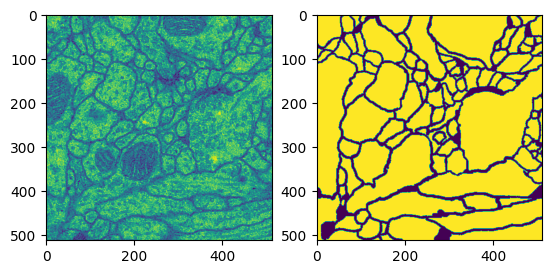

In [16]:
# data loader가 잘 되었는지 확인
train_data = MyDataset(data_dir=os.path.join(data_dir, 'train'))
data = train_data.__getitem__(0)
inputs = data['inputs']
labels = data['labels']

print('input shape', inputs.shape)
print('label shape', labels.shape)

# 시각화
plt.subplot(121)
plt.imshow(inputs)
plt.subplot(122)
plt.imshow(labels)

### 학습

In [17]:
# 변수설정
lr = 0.001
batch_size = 4
n_epoch = 100

# train model 저장경로
ckpt_dir = './checkpoint'

# cpu, gpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [18]:
train_transform = transforms.Compose([MyNormalization(),
                                      RandomFlip(),
                                      MyToTensor()])
test_transform = transforms.Compose([MyNormalization(),
                                     MyToTensor()])

In [19]:
# Dataset
train_set = MyDataset(data_dir=os.path.join(data_dir, 'train'), transform=train_transform)
val_set = MyDataset(data_dir=os.path.join(data_dir, 'val'), transform=train_transform)
test_set = MyDataset(data_dir=os.path.join(data_dir, 'test'), transform=test_transform)

In [20]:
# DataLoader
train_dl = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_dl = DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [21]:
# loss 추이 확인을 위한 변수 설정
num_data_train = len(train_set)
num_data_val = len(val_set)
num_data_test = len(test_set)

num_batch_train = np.ceil(num_data_train/batch_size)
num_batch_val = np.ceil(num_data_val/batch_size)
num_batch_test = np.ceil(num_data_test/batch_size)

In [22]:
# 모델
model = UNet().to(device)

fn_loss = nn.BCEWithLogitsLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [23]:
# 그 외 함수
fn_tonumpy = lambda x: x.to('cpu').detach().numpy().transpose(0, 2, 3, 1)
fb_denorm = lambda x, meam, std: (x*std)+mean
fn_class = lambda x: 1.0*(x>0.5)

In [24]:
# 모델 저장
def save_model(ckpt_dir, model, optim, epoch):
    if not os.path.exists(ckpt_dir):
        os.makedirs(ckpt_dir)
        
    torch.save({'model': model.state_dict(),
                'optim': optim.state_dict()},
                f'./{ckpt_dir}/model_{epoch:02d}.pth')

In [ ]:
# 모델학습
for epoch in range(n_epoch):
    model.train()
    batch_loss = []
    epoch_loss = []
    
    for batch, data in enumerate(train_dl, 1):
        labels = data['labels'].to(device)
        inputs = data['inputs'].to(device)
        
        output = model(inputs)
        
        loss = fn_loss(output, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # loss 계산
        batch_loss += [loss.item()]
        batch_loss_mean = np.mean(batch_loss)
    
    epoch_loss += [batch_loss_mean.item()]
    
    
# 모델 val
    with torch.no_grad():
        model.eval()
        loss_arr = []
        
        for batch, data in enumerate(val_dl, 1):
            labels = data['labels'].to(device)
            inputs = data['inputs'].to(device)
            
            output = model(inputs)
            
            loss = fn_loss(output, labels)
            loss_arr += [loss.item()]
    
    # epoch마다 모델 저장
    if epoch % 10 == 0:
        print(f'Train Epoch {epoch}/{n_epoch}\tLoss {np.mean(epoch_loss):.4f}')
        print(f'Valid Epoch {epoch}/{n_epoch}\tLoss {np.mean(loss_arr):.4f}')
        save_model(ckpt_dir=ckpt_dir, model=model, optim=optimizer, epoch=epoch)

### test

In [26]:
# 모델 불러오기
def load(ckpt_dir, model, optim):
    if not os.path.exists(ckpt_dir):
        epoch = 0
        return model, optim, epoch
    
    ckpt_lst = os.listdir(ckpt_dir)
    ckpt_lst.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))
    
    dict_model = torch.load(f'./{ckpt_dir}/{ckpt_lst[-1]}')
    
    model.load_state_dict(dict_model['model'])
    optim.load_state_dict(dict_model['optim'])
    epoch = int(ckpt_lst[-1].split('_')[1].split('.pth')[0])
    
    return model, optim, epoch

In [27]:
# 모델 테스트
st_epoch = 0
model, optimizer, st_epoch = load(ckpt_dir=ckpt_dir, model=model, optim=optimizer)

In [28]:
with torch.no_grad():
    model.eval()
    test_loss = []
    
    for batch, data in enumerate(test_dl, 1):
        labels = data['labels'].to(device)
        inputs = data['inputs'].to(device)

        output = model(inputs)

        loss = fn_loss(output, labels)
        test_loss += [loss.item()]
        
print(f'Test Batch {batch}/{num_batch_test}\tLoss {np.mean(test_loss)}')

Test Batch 1/1.0	Loss 0.6007803678512573


### output 시각화

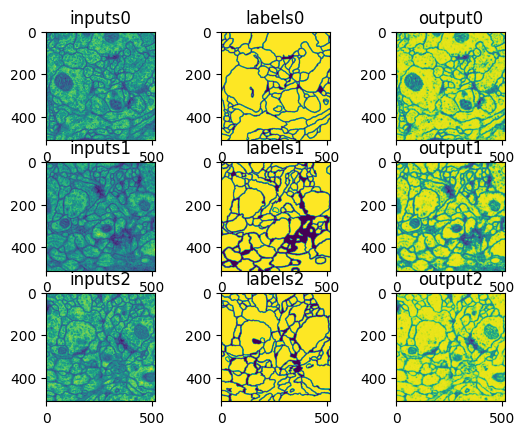

In [29]:
fig, axes = plt.subplots(output.shape[0], 3)
inputs = inputs.squeeze(1).cpu().detach().numpy()
labels = labels.squeeze(1).cpu().detach().numpy()
output = output.squeeze(1).cpu().detach().numpy()

for i in range(3):    
    inputs2 = inputs[i]
    labels2 = labels[i]
    output2 = output[i]
    
    axes[i, 0].imshow(inputs2)
    axes[i, 0].set_title(f'inputs{i}')
    axes[i, 1].imshow(labels2)
    axes[i, 1].set_title(f'labels{i}')
    axes[i, 2].imshow(output2)
    axes[i, 2].set_title(f'output{i}')
    
plt.show()